
<a id='lssm'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Modelos Linear de Estado de Espaço


<a id='index-0'></a>

## Conteúdo

- [Modelos Linear de Estado de Espaço](#Modelos-Linear-de-Estado-de-Espaço)  
  - [Resumo](#Resumo)  
  - [O Modelo Linear de Estado de Espaço](#O-Modelo-Linear-de-Estado-de-Espaço)  
  - [Distribuições e Momentos](#Distribuições-e-Momentos)  
  - [Estacionariedade e Ergodicidade](#Estacionariedade-e-Ergodicidade)  
  - [Observações Ruidosas](#Observações-Ruidosas)  
  - [Previsão](#Previsão)  
  - [Código](#Código)  
  - [Exercícios](#Exercícios)  
  - [Soluções](#Soluções)  

> *Devidamente traduzido, revisado e adaptado pelos bolsistas CNPq Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob a supervisão do Prof. Christiano Penna, do CAEN/UFC.*

> “Podemos considerar o estado atual do universo como o efeito de seu passado e a causa de seu futuro” – Marquês de Laplace

## Resumo

Esta aula apresenta o sistema dinâmico do estado de espaço linear .

Este modelo é um cavalo de batalha que carrega uma poderosa teoria da previsão.

Suas muitas aplicações incluem:

- representando a dinâmica de sistemas lineares de ordem superior 
- prediz a posição de um sistema $ j $ passos para o futuro 
- prever uma soma geométrica de valores futuros de uma variável como
  
  - receita não finaceira
  - dividendos de uma ação  
  - a oferta de moeda 
  - déficit ou superávit do governo etc.  
  
- Ingredientes chaves de modelos úteis  
  
  - Modelo de renda permanente de Friedman para suavização de consumo 
  - O modelo de Barro de suavizar a arrecadação total de impostos 
  - Versão de expectativas racionais do modelo de hiperinflação de Cagan  
  - "Aritmética monetarista desagradável" de Sargent e Wallace etc. 

### Configuração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics

## O Modelo Linear de Estado de Espaço


<a id='index-1'></a>
Os objetos em jogo são:

- Um vetor $ x_t $, $ n \times 1 $ denotando o **estado** nos momentos $ t = 0, 1, 2, \ldots $  
- Uma sequência *iid* $ m \times 1 $ de vetores aleatórios $ w_t \sim N(0,I) $  
- Um vetor $ y_t $, $ k \times 1 $ de **observações** nos momentos $ t = 0, 1, 2, \ldots $  
- Uma matriz $ A $, $ n \times n $  chamada de **matriz de transição**  
- Uma matriz $ C $, $ n \times m $  chamada de **matriz de volatilidade**  
- Uma matriz $ G $, $ k \times n $  às vezes chamada de **matriz de resultado**  

Aqui está o sistema de estado de espaço linear


<a id='equation-st-space-rep'></a>
$$
\begin{aligned}
    x_{t+1} & =  A x_t + C w_{t+1}   \\
    y_t &  =  G x_t \nonumber \\
    x_0 & \sim N(\mu_0, \Sigma_0) \nonumber
\end{aligned} \tag{1}
$$


<a id='lss-pgs'></a>

### Primitivas

As primitivas do modelo são

1. as matrizes $ A, C, G $  
1. distribuição de choque, que nos especializamos em $ N(0,I) $  
1. a distribuição de condição inicial $ x_0 $, que definimos $ N(\mu_0, \Sigma_0) $  


Dado $ A, C, G $ e extrai $ x_0 $ e $ w_1, w_2, \ldots $, o modelo [(1)](#equation-st-space-rep) define os valores das sequências $ \{x_t\} $ e $ \{y_t\} $

Mesmo sem esses empates, as primitivas 1 a 3 definem as * distribuições de probabilidade * de $ \{x_t\} $ e $ \{y_t\} $

Mais tarde, veremos como calcular essas distribuições e seus momentos.

#### Choques de diferença de Martingale


<a id='index-2'></a>
Assumimos que os choques são vetores normais padronizados independentes.

Mas parte do que dizemos será válida sob a suposição de que $ \{w_{t+1}\} $ é uma **sequência de diferenças de Martingale**

A sequência de diferença de Martingale is a sequence que tem média zero quando condicionada a informações passadas.

No caso presente, uma vez que $ \{x_t\} $ e nossa sequência de estado, isso significa que satisfaz

$$
\mathbb{E} [w_{t+1} | x_t, x_{t-1}, \ldots ] = 0
$$

Essa é uma condição mais fraca que  $ \{w_t\} $ que é *iid* com  $ w_{t+1} \sim N(0,I) $.

### Exemplos

Pela escolha apropriada das primitivas, uma variedade de dinâmicas pode ser representada em termos do modelo linear de estado de espaço.

Os exemplos a seguir ajudam a destacar esse ponto.

Eles também ilustram o ditado sábio que *considera o estado uma arte*.


<a id='lss-sode'></a>

#### Equação de Diferença de Segunda Ordem

Faça $ \{y_t\} $ ser uma sequência deterministica que satisfaz


<a id='equation-st-ex-1'></a>
$$
y_{t+1} =  \phi_0 + \phi_1 y_t + \phi_2 y_{t-1}
\quad \text{s.t.} \quad
y_0, y_{-1} \text{ given} \tag{2}
$$

Para mapear [(2)](#equation-st-ex-1) em nosso sistema de estado de espaço [(1)](#equation-st-space-rep), definimos

$$
x_t=
\begin{bmatrix}
    1 \\
    y_t \\
    y_{t-1}
\end{bmatrix}
\qquad
A = \begin{bmatrix}
          1 & 0 & 0 \\
          \phi_0 & \phi_1 & \phi_2  \\
          0 & 1 & 0
    \end{bmatrix}
\qquad
C= \begin{bmatrix}
    0 \\
    0 \\
    0
    \end{bmatrix}
\qquad
G = \begin{bmatrix} 0 & 1 & 0 \end{bmatrix}
$$

Você pode confirmar que, sob essas definições, [(1)](#equation-st-space-rep) e [(2)](#equation-st-ex-1) concordam

A próxima figura mostra a dinâmica desse processo quando $ \phi_0 = 1.1, \phi_1=0.8, \phi_2 = -0.8, y_0 = y_{-1} = 1 $


<a id='lss-sode-fig'></a>
![1](https://github.com/pluiz30/Julia-Hub/assets/60633407/31d0ab56-d8df-40fd-bfd9-b62ba30cea2d)
  
Mais tarde pediremos para você recriar essa figura.

#### Univariate Autoregressive Processes


<a id='index-3'></a>
Nós podemos usar [(1)](#equation-st-space-rep) para representar o modelo


<a id='equation-eq-ar-rep'></a>
$$
y_{t+1} = \phi_1 y_{t} + \phi_2 y_{t-1} + \phi_3 y_{t-2} + \phi_4  y_{t-3} + \sigma w_{t+1} \tag{3}
$$

onde $ \{w_t\} $ é iid e padrão-normal.

Para colocar isto no estado de espaço linear tomamos $ x_t = \begin{bmatrix} y_t & y_{t-1} &  y_{t-2} &  y_{t-3} \end{bmatrix}' $ e

$$
A =
\begin{bmatrix}
    \phi_1 & \phi_2 & \phi_3 & \phi_4 \\
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0
\end{bmatrix}
\qquad
C = \begin{bmatrix}
        \sigma \\
        0 \\
        0 \\
        0
    \end{bmatrix}
\qquad
 G = \begin{bmatrix}
         1 & 0  & 0 & 0
     \end{bmatrix}
$$

A matriz $ A $ tem a forma de *matriz companheira* para o vetor
$ \begin{bmatrix}\phi_1 &  \phi_2 & \phi_3 & \phi_4 \end{bmatrix} $.

A próxima figura mostra a dinâmica deste processo quando

$$
\phi_1 = 0.5, \phi_2 = -0.2, \phi_3 = 0, \phi_4 = 0.5, \sigma = 0.2, y_0 = y_{-1} = y_{-2} =
y_{-3} = 1
$$


<a id='lss-uap-fig'></a>
![2](https://github.com/pluiz30/Julia-Hub/assets/60633407/34747f81-8f0d-4225-99d7-4dd568ef3430)

#### Vetores Autoregressivos


<a id='index-4'></a>
Agora suponha que

- $ y_t $ é um vetor $ k \times 1 $   
- $ \phi_j $ é uma matriz $ k \times k $ e  
- $ w_t $ é $ k \times 1 $  


Então [(3)](#equation-eq-ar-rep) é denominado de um *vetor de autoregressão*

Para mapear isso dentro [(1)](#equation-st-space-rep), definimos

$$
x_t =
\begin{bmatrix}
     y_t \\
     y_{t-1} \\
     y_{t-2} \\
     y_{t-3}
 \end{bmatrix}
\quad
A =
\begin{bmatrix}
\phi_1 & \phi_2 & \phi_3 & \phi_4 \\
I & 0        & 0        & 0       \\
0 & I        & 0        & 0       \\
0 & 0        & I        & 0
\end{bmatrix}
\quad
C =
\begin{bmatrix}
     \sigma \\
     0 \\
     0 \\
     0
 \end{bmatrix}
\quad
G =
\begin{bmatrix}
     I & 0 & 0 & 0
 \end{bmatrix}
$$

Onde $ I $ é a matriz identidade $ k \times k $ é $ \sigma $ uma matriz $ k \times k $.

#### Sazonais 


<a id='index-5'></a>
Podemos usar [(1)](#equation-st-space-rep) para representar

1. A *sazonalidade determinística* $ y_t = y_{t-4} $  
1. A *sazonalidade não determinística* $ y_t = \phi_4 y_{t-4} + w_t $  


Em fato ambos são casos especiais de [(3)](#equation-eq-ar-rep)

Com a sazonalidade determinística, a matriz de transição se torna

$$
A = \begin{bmatrix}
        0 & 0 & 0 & 1 \\
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 1 & 0
    \end{bmatrix}
$$

É fácil verificar que $ A^4 = I $, que implica que $ x_t $ é estritamente periódico com o período 4:<sup><a href=#foot1 id=foot1-link>[1]</a></sup>

$$
x_{t+4} = x_t
$$

Tal processo $ x_t $ pode ser usado para modelar sazonalidades determinísticas em séries temporais trimestrais.

A sazonalidade *não determinística* produz flutuações sazonais recorrentes, mas aperiódicas.

#### Tendências de Tempo

<a id='index-6'></a>
O modelo $ y_t = a t + b $ é conhecido como um *modelo linear de tendências de tempo*

Podemos representar esse modelo na forma estado de espaço linear tomando

<a id='equation-lss-ltt'></a>
$$
A
= \begin{bmatrix}
    1 & 1  \\
    0 & 1
  \end{bmatrix}
\qquad
C
= \begin{bmatrix}
        0 \\
        0
  \end{bmatrix}
\qquad
G
= \begin{bmatrix}
        a & b
  \end{bmatrix} \tag{4}
$$

e começando na condição inicial $ x_0 = \begin{bmatrix} 0 & 1\end{bmatrix}' $

De fato, é possível usar o sistema de estados de espaço para representar tendências polinomiais de qualquer ordem

Por exemplo, faça 

$$
x_0
= \begin{bmatrix}
        0 \\
        0 \\
        1
  \end{bmatrix}
\qquad
A
= \begin{bmatrix}
    1 & 1 & 0 \\
    0 & 1 & 1 \\
    0 & 0 & 1
  \end{bmatrix}
\qquad
C
= \begin{bmatrix}
        0 \\
        0 \\
        0
  \end{bmatrix}
$$

Segue que

$$
A^t =
\begin{bmatrix}
 1 & t & t(t-1)/2 \\
 0 & 1 & t \\
 0 & 0 & 1
\end{bmatrix}
$$

Então $ x_t^\prime = \begin{bmatrix} t(t-1)/2 &t & 1 \end{bmatrix} $, de modo a $ x_t $ conter
tendências de tempo lineares e quadráticas.

### Representações de Médias Móveis 


<a id='index-7'></a>
Uma expressão não recursiva para $ x_t $ como uma função de
$ x_0, w_1, w_2, \ldots,  w_t $ pode ser encontrada usando [(1)](#equation-st-space-rep) repetidamente para obter


<a id='equation-eqob5'></a>
$$
\begin{aligned}
   x_t & = Ax_{t-1} + Cw_t \\
       & = A^2 x_{t-2} + ACw_{t-1} + Cw_t \nonumber \\
       & \qquad \vdots \nonumber \\
       & = \sum_{j=0}^{t-1} A^j Cw_{t-j}  + A^t x_0 \nonumber
\end{aligned} \tag{5}
$$

A representação [(5)](#equation-eqob5) é uma representação de *média móvel* 

Expressa $ \{x_t\} $ como uma função linear de 

1. valores atuais e passados do processo $ \{w_t\} $ e 
1. a condição inicial $ x_0 $  


Como exemplo de uma representação de média móvel, deixe o modelo ser

$$
A
= \begin{bmatrix}
    1 & 1  \\
    0 & 1
  \end{bmatrix}
\qquad
C
= \begin{bmatrix}
        1 \\
        0
  \end{bmatrix}
$$

Você será capaz de mostrar que $ A^t = \begin{bmatrix} 1 & t \cr 0 & 1 \end{bmatrix} $ e  $ A^j C = \begin{bmatrix} 1 & 0 \end{bmatrix}' $

Substituindo dentro de uma representação de média móvel [(5)](#equation-eqob5), obtemos

$$
x_{1t} = \sum_{j=0}^{t-1} w_{t-j} +
\begin{bmatrix}
 1 & t
\end{bmatrix}
x_0
$$

Onde $ x_{1t} $ é a primeira entrada de $ x_t $

O primeiro termo à direita é uma soma acumulada de diferenças de Martingale e, portanto, é um [martingale](https://en.wikipedia.org/wiki/Martingale_%28probability_theory%29)

O segundo termo é uma função linear traduzida pelo tempo

Por essa razão, $ x_{1t} $ é chamado de *Martingale com drift*

## Distribuições e Momentos


<a id='index-9'></a>

### Momentos Incondicionais

Usando [(1)](#equation-st-space-rep), é fácil obter expressões para médias
(incondicionais) de $ x_t $ e $ y_t $

Explicaremos o que significa incondicional e condicional em breve.

Deixando $ \mu_t := \mathbb{E} [x_t] $ e usando a linearidade das expectativas, nós
descobrimos que


<a id='equation-lss-mut-linear-models'></a>
$$
\mu_{t+1} = A \mu_t
\quad \text{com} \quad \mu_0 \text{ dado} \tag{6}
$$

Aqui $ \mu_0 $ é uma primitiva dado em [(1)](#equation-st-space-rep)

A matriz de variância e covariância de $ x_t $ é $ \Sigma_t := \mathbb{E} [ (x_t - \mu_t) (x_t - \mu_t)'] $

Usando $ x_{t+1} - \mu_{t+1} = A (x_t - \mu_t) + C w_{t+1} $, nós podemos
determinar essa matriz recursivamente via


<a id='equation-eqsigmalaw-linear-models'></a>
$$
\Sigma_{t+1}  = A \Sigma_t A' + C C'
\quad \text{dado} \quad \Sigma_0 \text{ com} \tag{7}
$$

Como com $ \mu_0 $, a matriz $ \Sigma_0 $ é uma primitiva dado em [(1)](#equation-st-space-rep)

Por uma questão de terminologia, às vezes chamaremos

- $ \mu_t $ a *média incondicional*  de $ x_t $  
- $ \Sigma_t $ a *matriz de variância e covariância incondicional*  de $ x_t $  


Isso é para distinguir $ \mu_t $ e $ \Sigma_t $ dos objetos relatados que usam condicionamento
informacional, a serem definidas abaixo

No entanto, você deve estar ciente de que esses momentos "incondicionais" dependem de
a distribuição inicial $ N(\mu_0, \Sigma_0) $.

#### Momentos das Observações

Usando a linearierdade das expectativas de novo


<a id='equation-lss-umy'></a>
$$
\mathbb{E} [y_t] = \mathbb{E} [G x_t] = G \mu_t \tag{8}
$$

A matriz de variância e covâriancia de  $ y_t $ é facilmente demonstrado ser


<a id='equation-lss-uvy'></a>
$$
\textrm{Var} [y_t] = \textrm{Var} [G x_t] = G \Sigma_t G' \tag{9}
$$

### Distribuições


<a id='index-10'></a>
Em geral, conhecer a matriz de média e variância-covariância de um vetor aleatório não é tão bom quanto conhecer a distribuição completa.

No entanto, existem algumas situações em que esses momentos sozinhos nos dizem tudo o que precisamos saber.

São situações em que o vetor médio e a matriz de covariância são **estatísticas suficientes** para a distribuição da população.

(Estatísticas suficientes formam uma lista de objetos que caracterizam uma distribuição populacional)

Uma dessas situações é quando o vetor em questão é gaussiano (isto é, normalmente distribuído).

Este é o caso aqui, dado

1. nossas suposições gaussianas sobre os primitivos  
1. o fato de que a normalidade é preservada sob operações lineares  


Em fato, é [sabido](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Affine_transformation) que


<a id='equation-lss-glig'></a>
$$
u \sim N(\bar u, S)
\quad \text{e} \quad
v = a + B u
\implies
v \sim N(a + B \bar u, B S B') \tag{10}
$$

Em particular, dadas as nossas suposições gaussianas sobre as primitivas e a linearidade de  [(1)](#equation-st-space-rep) podemos ver imediatamente que ambos $ x_t $ e
$ y_t $ são Gaussianos para todos $ t \geq 0 $ <sup><a href=#fn-ag id=fn-ag-link>[2]</a></sup>

Visto que $ x_t $ is Gaussiano, para encontrar a distribuição, tudo o que precisamos fazer é
encontre sua matriz de média e variância-covariância

Mas, na verdade, nós já fizemos isso, em [(6)](#equation-lss-mut-linear-models) e [(7)](#equation-eqsigmalaw-linear-models)

Deixando $ \mu_t $ e $ \Sigma_t $ ser como definido por essas equações,
temos


<a id='equation-lss-mgs-x'></a>
$$
x_t \sim N(\mu_t, \Sigma_t) \tag{11}
$$

Por raciocinio semelhante combinado com [(8)](#equation-lss-umy) e [(9)](#equation-lss-uvy),


<a id='equation-lss-mgs-y'></a>
$$
y_t \sim N(G \mu_t, G \Sigma_t G') \tag{12}
$$

### Interpretações do Conjunto 

Como devemos interpretar as distribuições definidas por [(11)](#equation-lss-mgs-x)–[(12)](#equation-lss-mgs-y)?

Intuitivamente, as probabilidades em uma distribuição correspondem a frequências relativas em uma grande população extraída dessa distribuição.

Vamos aplicar essa idéia à nossa configuração, focando na distribuição de  $ y_T $ para fixados $ T $

Podemos gerar empates independentes de $ y_T $ simulando repetidamente a evolução do sistema até o momento $ T $, usando um conjunto independente de choques a cada vez.

A figura a seguir mostra 20 simulações, produzindo 20 séries temporais para $ \{y_t\} $, e consequêntemente 20 empates de $ y_T $

O sistema em questão é um modelo autoregressivo univariado [(3)](#equation-eq-ar-rep)

Os valores de $ y_T $ são representados por pontos pretos na figura à esquerda

![3](https://github.com/pluiz30/Julia-Hub/assets/60633407/6565bf23-4ad4-4e0c-83aa-7dc909749210)
  
Na figura à direita, esses valores são convertidos em um histograma girado que mostra frequências relativas de nossa amostra de 20 $ y_T $’s



(Os parâmetros e o código fonte das figuras podem ser encontrados no arquivo [linear_models/paths_and_hist.jl](https://github.com/QuantEcon/lecture-source-jl/blob/master/rst_files/_static/code/linear_models/paths_and_hist.jl))

Aqui está outra figura, desta vez com 100 observações

![4](https://github.com/pluiz30/Julia-Hub/assets/60633407/18c803dd-eb29-4b40-829a-c5fa98ddc190)

Vamos agora tentar com 500.000 observações, mostrando apenas o histograma (sem rotação)

![5](https://github.com/pluiz30/Julia-Hub/assets/60633407/a72d13a3-dcdd-4195-a865-5940bebc6f56)
A linha preta é a densidade populacional de $ y_T $ calculado a partir de  [(12)](#equation-lss-mgs-y)

O histograma e a distribuição da população estão próximos, como esperado.

Observando as figuras e experimentando parâmetros, você terá uma ideia de como a distribuição da população depende das primitivas do modelo [listadas acima](#lss-pgs), intermediadas pelas estatísticas suficientes da distribuição.

#### Conjunto de Médias

Na figura anterior, aproximamos a distribuição populacional de $ y_T $ por

1. generando caminhos de amostra $ I $ (por exemplo, séries temporais) onde $ I $ é um número grande
1. gravando cada observação $ y^i_T $  
1. histogramando esta amostra  


Assim como o histograma se aproxima da distribuição da população, o *conjuto* ou
*média transversal*

$$
\bar y_T := \frac{1}{I} \sum_{i=1}^I y_T^i
$$

se aproxima da expectativa $ \mathbb{E} [y_T] = G \mu_T $ (como implícito na lei de grandes números)

Aqui está uma simulação comparando as médias do conjunto e as médias da população nos momentos  $ t=0,\ldots,50 $

Os parâmetros são os mesmos das figuras anteriores e o tamanho da amostra é relativamente pequeno ($ I=20 $)


<a id='lss-em-fig'></a>
![6](https://github.com/pluiz30/Julia-Hub/assets/60633407/83785715-523d-41ef-8397-c441161fb097)
  
O conjunto médio para $ x_t $ é

$$
\bar x_T := \frac{1}{I} \sum_{i=1}^I x_T^i \to \mu_T
\qquad (I \to \infty)
$$

O limite $ \mu_T $ é uma  “média de longo prazo”

(Por *média de longo prazo*, queremos dizer, a média de um infinito ($ I = \infty $) número da amostra $ x_T $’s)

Outra aplicação para a lei dos grande números assegura-nos

$$
\frac{1}{I} \sum_{i=1}^I (x_T^i - \bar x_T) (x_T^i - \bar x_T)' \to \Sigma_T
\qquad (I \to \infty)
$$

### Distribuições Conjuntas

Na discussão anterior, examinamos as distribuições de $ x_t $ e
$ y_t $ em isolamento

Isso nos fornece informações úteis, mas não nos permite responder perguntas como

- qual é a probabilidade de que $ x_t \geq 0 $ para todos $ t $?  
- qual é a probabilidade de o processo  $ \{y_t\} $ excede algum valor $ a $ antes de cair abaixo de $ b $?  
- etc., etc.  


Tais questões dizem respeito à *distribuição conjunta* dessas sequências.

Para calcular a distribuição conjunta de $ x_0, x_1, \ldots, x_T $, lembre-se
que as densidades conjuntas e condicionais estão ligadas pela regra

$$
p(x, y) = p(y \, | \, x) p(x)
\qquad \text{(joint }=\text{ condicional }\times\text{ marginal)}
$$

Dessa regra obtemos $ p(x_0, x_1) = p(x_1 \,|\, x_0) p(x_0) $

A propriedade de Markov $ p(x_t \,|\, x_{t-1}, \ldots, x_0) =  p(x_t \,|\, x_{t-1}) $ e repetidas aplicações da regra anterior nos levam a

$$
p(x_0, x_1, \ldots, x_T) =  p(x_0) \prod_{t=0}^{T-1} p(x_{t+1} \,|\, x_t)
$$

A $ p(x_0) $ marginal,  é apenas o primitivo $ N(\mu_0, \Sigma_0) $

Tendo em vista [(1)](#equation-st-space-rep), as densidades condicionais são

$$
p(x_{t+1} \,|\, x_t) = N(Ax_t, C C')
$$

#### Funções de Autocovariância

Um objeto importante relacionado à distribuição conjunta é a *função de autocovariância*


<a id='equation-eqnautodeff'></a>
$$
\Sigma_{t+j, t} := \mathbb{E} [ (x_{t+j} - \mu_{t+j})(x_t - \mu_t)' ] \tag{13}
$$

Cálculos elementares mostram que


<a id='equation-eqnautocov'></a>
$$
\Sigma_{t+j,t} = A^j \Sigma_t \tag{14}
$$

Perceba que $ \Sigma_{t+j,t} $ em geral depende de ambos $ j $, a diferença entre as duas datas, e $ t $, a data anterior.

## Estacionariedade e Ergodicidade


<a id='index-12'></a>
Estacionariedade e ergodicidade são duas propriedades que, quando mantidas,  auxiliam bastante a análise de modelos lineares de estados de espaço.

Começaremos com a intuição.

### Vizualizando a Estabilidade

Vejamos mais algumas séries temporais do mesmo modelo que analisamos acima.

Esta figura mostra distribuições transversais para $ y $ nos momentos
$ T, T', T'' $

![7](https://github.com/pluiz30/Julia-Hub/assets/60633407/9da9ed50-46b1-4fda-902f-0de801aad87f)
  
Observe como a série temporal se "acalma" no sentido de que as distribuições em 
$ T' $ e $ T'' $ são relativamente semelhantes entre si — mas, diferentemente da distribuição em $ T $

Aparentemente, as distribuições de $ y_t $ convergem para uma distribuição fixa de longo prazo como $ t \to \infty $

Quando existe uma distribuição, é chamada de *distribuição estacionária*

### Distribuições Estacionárias

Em nosso cenário, uma distribuição $ \psi_{\infty} $ é dito ser *estacionária* para $ x_t $ se

$$
x_t \sim \psi_{\infty}
\quad \text{e} \quad
x_{t+1} = A x_t + C w_{t+1}
\quad \implies \quad
x_{t+1} \sim \psi_{\infty}
$$

Visto que

1.  presente caso, todas as distribuições são Gaussianas 
1. uma distribuição Gaussiana é definida por sua matriz de média e variância-covariância 


podemos reafirmar a definição da seguinte forma:  $ \psi_{\infty} $ é estacionária para $ x_t $ if

$$
\psi_{\infty}
= N(\mu_{\infty}, \Sigma_{\infty})
$$

onde $ \mu_{\infty} $ and $ \Sigma_{\infty} $ são pontos fixos de [(6)](#equation-lss-mut-linear-models) e [(7)](#equation-eqsigmalaw-linear-models) respectivamente.

### Processos Estacionários de Covariância

Vamos ver o que acontece com a figura anterior, se começarmos $ x_0 $ na distribuição estacionária


<a id='lss-s-fig'></a>

![8](https://github.com/pluiz30/Julia-Hub/assets/60633407/524fe11c-3941-4d5e-8127-00fcebb52881)
  
Agora as diferenças nas distribuições observadas em $ T, T' $ and $ T'' $ provêm inteiramente de flutuações aleatórias devido ao tamanho finito da amostra

By

- nossa escolha  $ x_0 \sim N(\mu_{\infty}, \Sigma_{\infty}) $  
- as definições de $ \mu_{\infty} $ e $ \Sigma_{\infty} $ como pontos fixos de [(6)](#equation-lss-mut-linear-models) e [(7)](#equation-eqsigmalaw-linear-models) respectivamente 


nós garantimos que

$$
\mu_t = \mu_{\infty}
\quad \text{and} \quad
\Sigma_t = \Sigma_{\infty}
\quad \text{for all } t
$$

Além disso, em vista de [(14)](#equation-eqnautocov), a função de autocovariância assume a forma $ \Sigma_{t+j,t} = A^j \Sigma_\infty $, que depende de $ j $ mas não em $ t $

Isso motiva a seguinte definição

Um processo $ \{x_t\} $ é dito ser *covariância estacionário* se

- Ambos $ \mu_t $ e $ \Sigma_t $ são constantes em $ t $  
- $ \Sigma_{t+j,t} $ depende do intervalo de tempo $ j $ mas não a tempo $ t $  


Em nossa configuração, $ \{x_t\} $ será covariância estacionário se $ \mu_0, \Sigma_0, A, C $  assumir valores que implicam que nenhum dos $ \mu_t, \Sigma_t, \Sigma_{t+j,t} $ depende do $ t $

### Condições para Estacionariedade

#### O Caso Globalmente Estável

A equação da diferenca $ \mu_{t+1} = A \mu_t $ é conhecido por ter um ponto fixo *único* $ \mu_{\infty} = 0 $ se todos os autovalores de $ A $ têm módulos estritamente menores que a unidade.

Ou seja, se  `all(abs(eigvals(A)) .< 1) == true`

A equação da diferença [(7)](#equation-eqsigmalaw-linear-models) atambém possui um ponto fixo único nesse caso e, além disso,

$$
\mu_t \to \mu_{\infty} = 0
\quad \text{and} \quad
\Sigma_t \to \Sigma_{\infty}
\quad \text{as} \quad t \to \infty
$$

independentemente das condições iniciais  $ \mu_0 $ e $ \Sigma_0 $

Isso é o *caso globalmente estável* — veja <a href=/_static/pdfs/iteration_notes.pdf download>essas notas</a> para mais um tratamento teórico

No entanto, a estabilidade global é mais do que precisamos para soluções estacionárias e, muitas vezes, mais do que queremos.

Para ilustrar, considere [nosso exemplo de equação de diferença de segunda ordem](#lss-sode)

Aqui o estado é $ x_t = \begin{bmatrix} 1 & y_t & y_{t-1} \end{bmatrix}' $

Devido ao  primeiro componente constante no vetor de estado, nunca teremos $ \mu_t \to 0 $

Como podemos encontrar soluções estacionárias que respeitam um componente de estado constante?

#### Processos com um Componente de Estado Constante 

Para investigar tal processo, suponha que $ A $ e $ C $ assuma a forma


$$
A
 = \begin{bmatrix}
    A_1 & a \\
    0 & 1
\end{bmatrix}
 \qquad
 C  = \begin{bmatrix}
     C_1 \\
     0
\end{bmatrix}
$$

Onde

- $ A_1 $ é uma matriz $ (n-1) \times (n-1) $
- $ a $ é um vetor coluna $ (n-1) \times 1 $   


faça $ x_t = \begin{bmatrix} x_{1t}' & 1 \end{bmatrix}' $ onde $ x_{1t} $ é $ (n-1) \times 1 $

Segue que

$$
\begin{aligned}
x_{1,t+1} & = A_1 x_{1t} + a + C_1 w_{t+1} \\
\end{aligned}
$$

faça $ \mu_{1t} = \mathbb{E} [x_{1t}] $ assumir expectativas de ambos os lados desta expressão para obter


<a id='equation-eqob29'></a>
$$
\mu_{1,t+1} = A_1 \mu_{1,t} + a \tag{15}
$$

Presuma agora que o módulo dos autovalores de $ A_1 $ são estritamente menores que um

Então [(15)](#equation-eqob29) tem uma única solução estacionária, nomeada,

$$
\mu_{1\infty} = (I-A_1)^{-1} a
$$

O valor estacionário de $ \mu_t $ em si é então $ \mu_\infty := \begin{bmatrix}
\mu_{1\infty}' & 1 \end{bmatrix}' $

Os valores estacionários de $ \Sigma_t $ e $ \Sigma_{t+j,t} $ satisfazem


<a id='equation-eqnsigmainf'></a>
$$
\begin{aligned}
\Sigma_\infty  & = A \Sigma_\infty A' + C C' \\
\Sigma_{t+j,t} & = A^j \Sigma_\infty \nonumber
\end{aligned} \tag{16}
$$

Perceba que aqui $ \Sigma_{t+j,t} $ depende do intervalo de tempo $ j $ mas não o tempo do *calendário* $ t $

Concluindo, se

- $ x_0 \sim N(\mu_{\infty}, \Sigma_{\infty}) $ e
- o módulo dos autovalores de $ A_1 $ são estritamente menores que a unidade  


então o processo $ \{x_t\} $ covariância estacionário, com componente de estado constante

>**Nota**
>
> Se os autovalores de $ A_1 $ são menores que a unidade em módulo, então (a) a partir de qualquer valor inicial, a matriz de média e variância-covariância converge para seus valores estacionários; e (b) as iterações em [(7)](#equation-eqsigmalaw-linear-models) convergem para o ponto fixo da *equação discreta de Lyapunov*  na primeira linha de [(16)](#equation-eqnsigmainf).

### Ergodicidade

Vamos supor que estamos trabalhando com um processo estacionário de covariância.

Nesse caso, sabemos que a média do conjunto irá convergir para $ \mu_{\infty} $ como o tamanho da amostra $ I $ se aproxima do infinito.

#### Médias ao Longo do tempo

As médias de conjuntos entre simulações são interessantes teoricamente, mas na vida real geralmente observamos apenas uma única realização $ \{x_t, y_t\}_{t=0}^T $

Então agora vamos dar uma única realização e formar as médias de séries temporais

$$
\bar x := \frac{1}{T} \sum_{t=1}^T x_t
\quad \text{e} \quad
\bar y := \frac{1}{T} \sum_{t=1}^T y_t
$$

Essas médias de séries temporais convergem para algo interpretável em termos de nossa representação básica do espaço de estados?

A resposta depende de algo chamado *ergodicidade*.

Ergodicidade é a propriedade em que as médias de séries temporais e de conjuntos coincidem.

Mais formalmente, a ergodicidade implica que as médias das amostras de séries temporais convergem para suas expectativas sob a distribuição estacionária.

Em particular,

- $ \frac{1}{T} \sum_{t=1}^T x_t \to \mu_{\infty} $  
- $ \frac{1}{T} \sum_{t=1}^T (x_t -\bar x_T) (x_t - \bar x_T)' \to \Sigma_\infty $  
- $ \frac{1}{T} \sum_{t=1}^T (x_{t+j} -\bar x_T) (x_t - \bar x_T)' \to A^j \Sigma_\infty $  


Em nosso cenário gaussiano linear, qualquer processo estacionário de covariância também é ergódico.

## Observações Ruidosas

Em alguns cenários, a equação de observação $ y_t = Gx_t $ t é modificado para incluir um termo de erro.

Muitas vezes, esse termo de erro representa a ideia de que o estado verdadeiro só pode ser observado imperfeitamente.

Para incluir um termo de erro na observação, introduzimos

- Uma sequência *iid*  $ \ell \times 1 $ de vetores aleatórios $ v_t \sim N(0,I) $  
- Uma matriz $ H $ $ k \times \ell $    


e estendemos o sistema linear de estados de espaço para


<a id='equation-st-space-rep-noisy'></a>
$$
\begin{aligned}
    x_{t+1} & =  A x_t + C w_{t+1}   \\
    y_t &  =  G x_t + H v_t \nonumber \\
    x_0 & \sim N(\mu_0, \Sigma_0) \nonumber
\end{aligned} \tag{17}
$$

A sequência $ \{v_t\} $ está considerando independente de  $ \{w_t\} $

O processo  $ \{x_t\} $ não é modificado pelo ruído na equação de observação e seus momentos, distribuições e propriedades de estabilidade permanecem os mesmos.

Os momentos incondicionais de $ y_t $ de [(8)](#equation-lss-umy) e [(9)](#equation-lss-uvy)
agora se tornam


<a id='equation-lss-umy-2'></a>
$$
\mathbb{E} [y_t] = \mathbb{E} [G x_t + H v_t] = G \mu_t \tag{18}
$$

A matriz de variância-covariância $ y_t $ é facilmente demonstrado ser


<a id='equation-lss-uvy-2'></a>
$$
\textrm{Var} [y_t] = \textrm{Var} [G x_t + H v_t] = G \Sigma_t G' + HH' \tag{19}
$$

A distribuição $ y_t $ é portanto

$$
y_t \sim N(G \mu_t, G \Sigma_t G' + HH')
$$

## Previsão


<a id='index-13'></a>
A teoria da previsão para sistemas lineares de espaço de estados é elegante e simples.

<a id='ff-cm'></a>

### Fórmulas de Previsão  – Médias Condicionais

A maneira natural de prever variáveis é usar distribuições condicionais.

Por exemplo, a previsão ideal de $ x_{t+1} $ 1 dada informação conhecida no momento  $ t $ é 

$$
\mathbb{E}_t [x_{t+1}] := \mathbb{E} [x_{t+1} \mid x_t, x_{t-1}, \ldots, x_0 ] = Ax_t
$$

O lado direito segue de $ x_{t+1} = A x_t + C w_{t+1} $ e o fato de que $ w_{t+1} $ é média zero e independente de $ x_t, x_{t-1}, \ldots, x_0 $

Que $ \mathbb{E}_t [x_{t+1}] = \mathbb{E}[x_{t+1} \mid x_t] $ é uma implicação de $ \{x_t\} $ tendo a  *propriedade de Markov*

Um passo adiante da previsão do erro é

$$
x_{t+1} - \mathbb{E}_t [x_{t+1}] = Cw_{t+1}
$$

A matriz de covariância do erro de previsão é

$$
\mathbb{E} [ (x_{t+1} - \mathbb{E}_t [ x_{t+1}] ) (x_{t+1} - \mathbb{E}_t [ x_{t+1}])'] = CC'
$$

Em geral, gostaríamos de calcular $ j $-previsões à frente $ \mathbb{E}_t [x_{t+j}] $ e $ \mathbb{E}_t [y_{t+j}] $

Com um pouco de álgebra obtemos

$$
x_{t+j} = A^j x_t + A^{j-1} C w_{t+1} + A^{j-2} C w_{t+2}
+ \cdots + A^0 C w_{t+j}
$$

Tendo em vista a propriedade *iid*, os valores do estado atual e do passado não fornecem informações sobre os valores futuros do choque.

Logo $ \mathbb{E}_t[w_{t+k}] = \mathbb{E}[w_{t+k}] = 0 $

Segue-se agora a partir da linearidade das expectativas que os $ j $-previsões a frente de $ x $ é

$$
\mathbb{E}_t [x_{t+j}] = A^j x_t
$$

As $ j $-previsões a frente de $ y $ é portanto

$$
\mathbb{E}_t [y_{t+j}]
= \mathbb{E}_t [G x_{t+j} + H v_{t+j}]
= G A^j x_t
$$

### Covariância de Erros de Previsão

É usual obter a matriz de covariância do vetor de $ j $-passos a frente de erros de previsão


<a id='equation-eqob8'></a>
$$
x_{t+j} - \mathbb{E}_t [ x_{t+j}] = \sum^{j-1}_{s=0} A^s C w_{t-s+j} \tag{20}
$$

Evidentemente,


<a id='equation-eqob9a'></a>
$$
V_j := \mathbb{E}_t [ (x_{t+j} - \mathbb{E}_t [x_{t+j}] ) (x_{t+j} - \mathbb{E}_t [x_{t+j}] )^\prime ] =   \sum^{j-1}_{k=0} A^k C C^\prime A^{k^\prime} \tag{21}
$$

$ V_j $ definido em [(21)](#equation-eqob9a) pode ser calculado recursivamente $ V_1 = CC' $ e


<a id='equation-eqob9b'></a>
$$
V_j = CC^\prime + A V_{j-1} A^\prime, \quad j \geq 2 \tag{22}
$$

$ V_j $ é a *matriz de covariância condicional* dos erros na previsão
$ x_{t+j} $, condicionado ao tempo $ t $ dado $ x_t $

Sob condições particulares, $ V_j $ converge para


<a id='equation-eqob10'></a>
$$
V_\infty = CC' + A V_\infty A' \tag{23}
$$

A equação [(23)](#equation-eqob10) é um exemplo de uma equação *discreta de Lyapunov* na matriz de covariância $ V_\infty $

Uma condição suficiente para $ V_j $ convergir é que os autovalores de $ A $ seja estritamente menores que 1 em módulo.

Condições mais fracas para convergência associam valores próprios iguais ou superiores a um no módulo aos elementos de $ C $ que é igual $ 0 $


<a id='lm-fgs'></a>

### Previsões de Somas Geométricas

Em muitos contextos, queremos calcular previsões de somas geométricas de futuras variáveis aleatórias governadas pelo sistema linear de espaço de estados [(1)](#equation-st-space-rep)

Queremos os seguintes objetos

- Previsão de uma soma geométrica dos futuros $ x $’s, ou $ \mathbb{E}_t \left[ \sum_{j=0}^\infty \beta^j x_{t+j} \right] $  
- Previsão de uma soma geométrica dos futuros $ y $’s, ou $ \mathbb{E}_t \left[\sum_{j=0}^\infty \beta^j y_{t+j} \right] $  


Esses objetos são componentes importantes de alguns modelos dinâmicos famosos e interessantes.

Por exemplo,

- Se $ \{y_t\} $ é um fluxo de dividendos, então $ \mathbb{E} \left[\sum_{j=0}^\infty \beta^j y_{t+j} | x_t \right] $ é um modelo de preços de ações  
- Se $ \{y_t\} $ é a oferta de moeda, então $ \mathbb{E} \left[\sum_{j=0}^\infty \beta^j y_{t+j} | x_t \right] $ é um modelo de nível de preços.

#### Fórmulas

Felizmente, é fácil usar um pouco de álgebra matricial para calcular esses objetos.

Suponha que todo autovalor de f $ A $ possui módulo estritamente $ \frac{1}{\beta} $

Ele [então segue](https://julia.quantecon.org/tools_and_techniques/linear_algebra.html#la-neumann-remarks) que $ I + \beta A + \beta^2 A^2 + \cdots = \left[I - \beta A \right]^{-1} $

Isso leva às nossas fórmulas:

- Previsão de uma soma geométrica dos futuros $ x $’s  


$$
\mathbb{E}_t \left[\sum_{j=0}^\infty \beta^j x_{t+j} \right]
= [I + \beta A + \beta^2 A^2 + \cdots \ ] x_t = [I - \beta A]^{-1} x_t
$$

- Previsão de uma soma geométrica dos futuros $ y $’s  


$$
\mathbb{E}_t \left[\sum_{j=0}^\infty \beta^j y_{t+j} \right]
= G [I + \beta A + \beta^2 A^2 + \cdots \ ] x_t
= G[I - \beta A]^{-1} x_t
$$

## Código

Nossas simulações e cálculos anteriores são baseados no código no arquivo [lss.jl](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/lss.jl) do pacote [QuantEcon.jl](http://quantecon.org/julia_index.html)

O código implementa um tipo no qual os modelos lineares de estados de espaço podem atuar diretamente através de métodos específicos (para simulações, momentos de cálculo etc.).

Exemplos de uso são dados nas soluções para os exercícios.

## Exercícios


<a id='lss-ex1'></a>

### Exercício 1

Replique [essa figura](#lss-sode-fig) usando o tipo `LSS` a partir de`lss.jl`


<a id='lss-ex2'></a>

### Exercício 2

Replique [essa figura](#lss-uap-fig)  usando o mesmo tipo de aleatoriedade do módulo


<a id='lss-ex3'></a>

### Exercício 3

Replique [essa figura](#lss-em-fig)  usando o mesmo tipo de aleatoriedade do módulo

O modelo e os parâmetros do estado de espaço são os mesmos do exercício anterior.


<a id='lss-ex4'></a>

### Exercício 4

Replique [essa figura](#lss-s-fig) usando o mesmo tipo de aleatoriedade do módulo

O modelo e os parâmetros do estado de espaço são os mesmos do exercício anterior, exceto que a condição inicial é a distribuição estacionária.

Dica: você pode usar o método `stationary_distributions` para obter as condições iniciais

O número de caminhos de amostra é 80 e o horizonte de tempo na figura é 100.

A produção de barras e pontos verticais é opcional, mas se você quiser tentar, as barras estão nas datas 10, 50 e 75.

## Soluções

In [3]:
using QuantEcon, Plots
gr(fmt=:png);

### Exercício 1

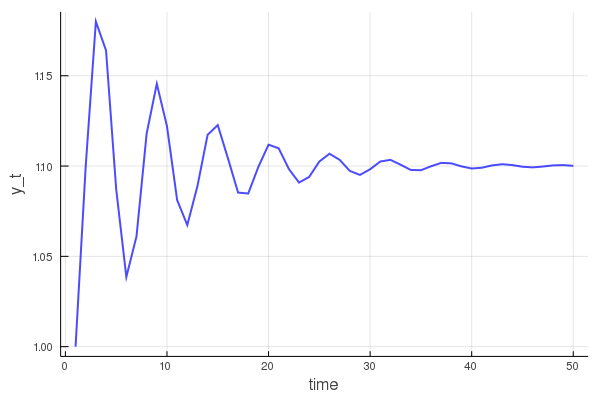

In [4]:
ϕ0, ϕ1, ϕ2 = 1.1, 0.8, -0.8

A = [1.0   0.0   0
        ϕ0    ϕ1    ϕ2
        0.0   1.0   0.0]
C = zeros(3, 1)
G = [0.0 1.0 0.0]
μ_0 = ones(3)

lss = LSS(A, C, G; mu_0=μ_0)

x, y = simulate(lss, 50)
plot(dropdims(y, dims = 1), color = :blue, linewidth = 2, alpha = 0.7)
plot!(xlabel="time", ylabel = "y_t", legend = :none)

### Exercício 2

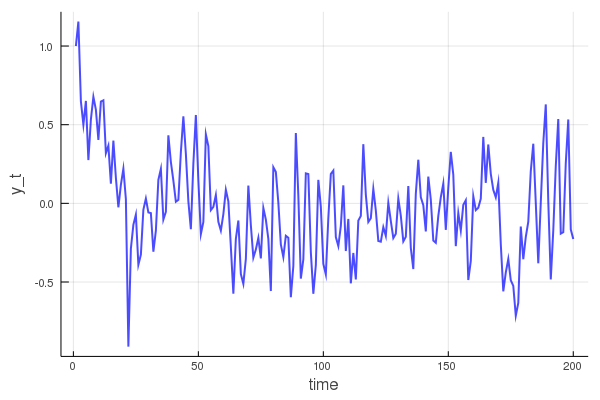

In [5]:
using Random
Random.seed!(42) # Para resultados determinísticos.

ϕ1, ϕ2, ϕ3, ϕ4 = 0.5, -0.2, 0, 0.5
σ = 0.2

A = [ϕ1     ϕ2    ϕ3    ϕ4
        1.0   0.0   0.0   0.0
        0.0   1.0   0.0   0.0
        0.0   0.0   1.0   0.0]
C = [σ
        0.0
        0.0
        0.0]''
G = [1.0 0.0 0.0 0.0]

ar = LSS(A, C, G; mu_0 = ones(4))
x, y = simulate(ar, 200)

plot(dropdims(y, dims = 1), color = :blue, linewidth = 2, alpha = 0.7)
plot!(xlabel="time", ylabel = "y_t", legend = :none)

### Exercício 3

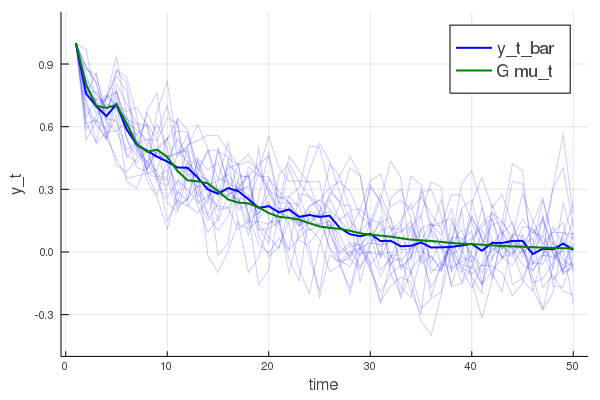

In [6]:
ϕ1, ϕ2, ϕ3, ϕ4 = 0.5, -0.2, 0, 0.5
σ = 0.1

A = [ ϕ1    ϕ2    ϕ3    ϕ4
        1.0   0.0   0.0   0.0
        0.0   1.0   0.0   0.0
        0.0   0.0   1.0   0.0]
C = [σ
        0.0
        0.0
        0.0]
G = [1.0 0.0 0.0 0.0]
I = 20
T = 50
ar = LSS(A, C, G; mu_0 = ones(4))
ymin, ymax = -0.5, 1.15

ensemble_mean = zeros(T)
ys = []
for i ∈ 1:I
    x, y = simulate(ar, T)
    y = dropdims(y, dims = 1)
    push!(ys, y)
    ensemble_mean .+= y
end

ensemble_mean = ensemble_mean ./ I
plot(ys, color = :blue, alpha = 0.2, linewidth = 0.8, label = "")
plot!(ensemble_mean, color = :blue, linewidth = 2, label = "y_t_bar")
m = moment_sequence(ar)
pop_means = zeros(0)
for (i, t) ∈ enumerate(m)
    (μ_x, μ_y, Σ_x, Σ_y) = t
    push!(pop_means, μ_y[1])
    i == 50 && break
end
plot!(pop_means, color = :green, linewidth = 2, label = "G mu_t")
plot!(ylims=(ymin, ymax), xlabel = "time", ylabel = "y_t", legendfont = font(12))

### Exercício 4

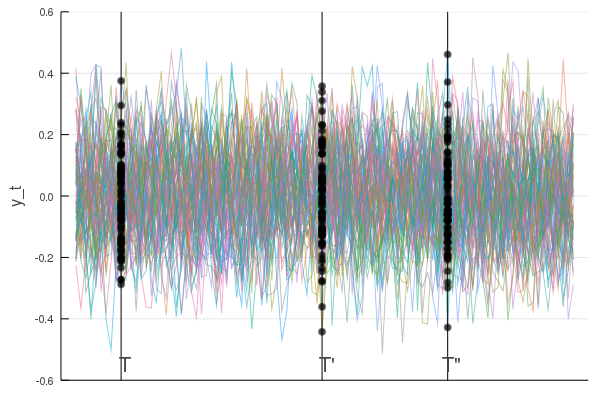

In [7]:
ϕ1, ϕ2, ϕ3, ϕ4 = 0.5, -0.2, 0, 0.5
σ = 0.1

A = [ϕ1     ϕ2    ϕ3    ϕ4
        1.0   0.0   0.0   0.0
        0.0   1.0   0.0   0.0
        0.0   0.0   1.0   0.0]
C = [σ
        0.0
        0.0
        0.0]''
G = [1.0 0.0 0.0 0.0]

T0 = 10
T1 = 50
T2 = 75
T4 = 100

ar = LSS(A, C, G; mu_0 = ones(4))
ymin, ymax = -0.6, 0.6

μ_x, μ_y, Σ_x, Σ_y = stationary_distributions(ar)
ar = LSS(A, C, G; mu_0=μ_x, Sigma_0=Σ_x)
colors = ["c", "g", "b"]

ys = []
x_scatter = []
y_scatter = []
for i ∈ 1:80
    rcolor = colors[rand(1:3)]
    x, y = simulate(ar, T4)
    y = dropdims(y, dims = 1)
    push!(ys, y)
    x_scatter = [x_scatter; T0; T1; T2]
    y_scatter = [y_scatter; y[T0]; y[T1]; y[T2]]
end

plot(ys, linewidth = 0.8, alpha = 0.5)
plot!([T0 T1 T2; T0 T1 T2], [-1 -1 -1; 1 1 1], color = :black, legend = :none)
scatter!(x_scatter, y_scatter, color = :black, alpha = 0.5)
plot!(ylims=(ymin, ymax), ylabel = "y_t", xticks =[], yticks = ymin:0.2:ymax)
plot!(annotations = [(T0+1, -0.55, "T");(T1+1, -0.55, "T'");(T2+1, -0.55, "T''")])

**Notas de rodapé**

<p><a id=foot1 href=#foot1-link><strong>[1]</strong></a> Os autovalores de $ A $ são $ (1,-1, i,-i) $.

<p><a id=fn-ag href=#fn-ag-link><strong>[2]</strong></a> A maneira correta de argumentar isso é por indução. Suponha que
$ x_t $ é Guassiano.  Então [(1)](#equation-st-space-rep) e
[(10)](#equation-lss-glig) implica que $ x_{t+1} $ é Guassiano.  De modo que $ x_0 $
assumido como Guassiano, segue se que todo $ x_t $ é Guassiano.
Evidencialmente isso implica que cada $ y_t $ é Guassiano.